In [1]:
%matplotlib inline
import pandas as pd
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

# File with functions from prior notebook(s)
from myfunk import *

pd.set_option('precision', 2)

/Users/iZbra1/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load Data

In [2]:
int_data = '../data/processed/dayta.csv'
dayta = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
int_data = '../data/processed/week_data.csv'
week_data = pd.read_csv(int_data, index_col=0, parse_dates=['date'])

## 5. In any normal day, is there a pattern of the usage over the course of time? Can we predict the count of bikers given the time, day and weather?

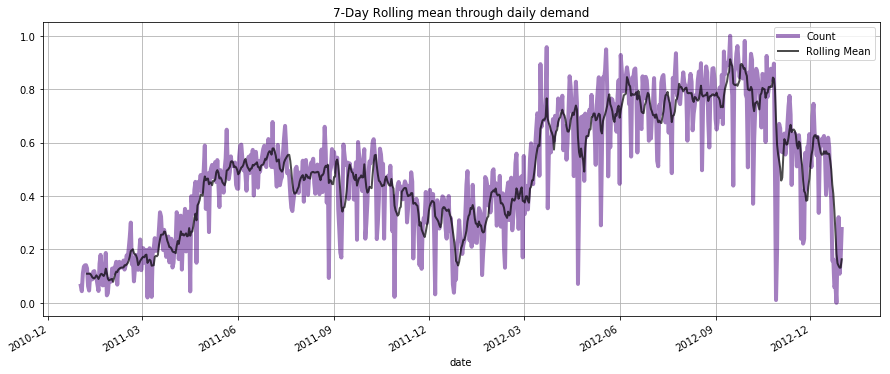

In [3]:
fig = plt.figure(figsize=(15,6))
plt.plot(dayta.index.values, dayta.nCnt, color='indigo', linewidth=4, label='Count',alpha=0.5)
dayta.nCnt.rolling(window=7).mean().plot(style=['k'],linewidth=2, label='Rolling Mean', alpha=0.7)
plt.title('7-Day Rolling mean through daily demand')
plt.grid('on')
plt.legend()
plt.show()
fig.savefig('../reports/img/Q57DayRollingMean.png', bbox_inches='tight')

I will use the weekly-average to reduce the seasonality and trend of the above signal. Then the demand will go through a smoothing process of 2 days average. 

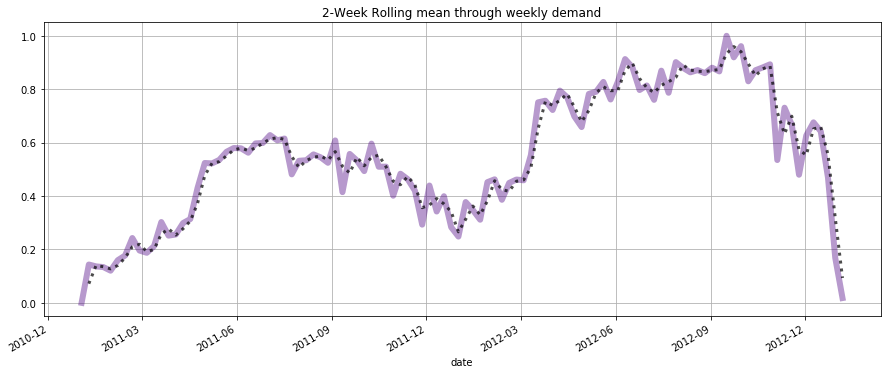

In [4]:
week_data['smoothed'] = week_data.nCnt.rolling(window=2).mean()

plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=6, label='Count', alpha=0.4)
week_data.nCnt.rolling(window=2).mean().plot(style=['k:'],linewidth=3, alpha=0.7)
plt.title('2-Week Rolling mean through weekly demand')
plt.grid('on')
plt.show()

In [5]:
week_data.set_value('2011-01-02', 'smoothed', 0)   # Fill in the Smoothed out value
week_data.head(2)

,season,year,weather_condition,temp,atemp,windspeed,humidity,casual,registered,cnt,nCasual,nRegistered,nCnt,smoothed
date,,,,,,,,,,,,,,
2011-01-02,1,2011,2.0,0.36,0.35,0.25,0.77,460,1312,1772,1.80e-03,0.00,0.00,0.00
2011-01-09,1,2011,1.0,0.20,0.20,0.19,0.47,668,8747,9415,1.96e-02,0.17,0.14,0.07


In [6]:
# keep only useful columns
df_week = week_data.loc[:, ['season','atemp','nCnt','smoothed']]
df_week = pd.get_dummies(df_week, columns=['season'])
df_week.head()

,atemp,nCnt,smoothed,season_1,season_2,season_3,season_4
date,,,,,,,
2011-01-02,0.35,0.00,0.00,1,0,0,0
2011-01-09,0.20,0.14,0.07,1,0,0,0
2011-01-16,0.18,0.14,0.14,1,0,0,0
2011-01-23,0.20,0.13,0.14,1,0,0,0
2011-01-30,0.21,0.12,0.13,1,0,0,0


There is some seasonailty between the 2 years and also an increasing trend. 

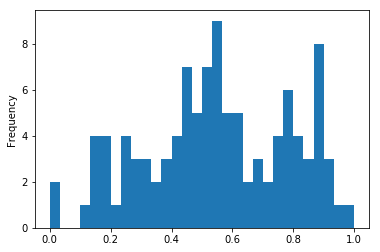

In [7]:
df_week.nCnt.plot(kind = "hist", bins = 30);

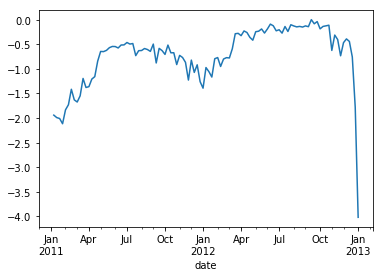

In [8]:
# get log of the power
df_week['log_power'] = df_week.nCnt.apply(lambda x: np.log(x))
df_week.log_power.plot()

The log transformation doesnt help the plot to become flatter so, it's not a useful thing to do. 

In [9]:
df_week.drop('log_power', axis=1, inplace=True)

Let's divide the dataset and test the model against the last 5 months

In [10]:
week_train = df_week.iloc[:-23].copy()
week_test = df_week.iloc[-23:].copy()

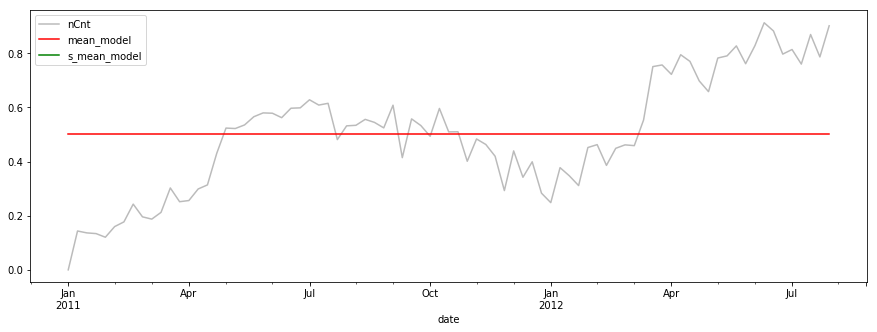

In [11]:
# Mean 
week_mean = week_train.nCnt.mean()
week_train['mean_model'] = week_mean
week_train.loc[:, ['nCnt','mean_model','s_mean_model']].plot(color=['#bbbbbb','r','g'], figsize=(15,5));

In [12]:
model_mean_RMSE = RMSE(week_train.mean_model, week_train.nCnt)
model_mean_RMSE

0.21454293332996938

In [13]:
# Save this in a dataframe
results_week = pd.DataFrame(columns=["Model", "RMSE"])
results_week.loc[0,"Model"] = "Mean"
results_week.loc[0,"RMSE"] = model_mean_RMSE
results_week

,Model,RMSE
0,Mean,0.21


In [14]:
# Convert date in datetimedelta figure starting from zero
week_train["time_index"] = np.arange(1,len(week_train)+1)
week_train.tail()

,atemp,nCnt,smoothed,season_1,season_2,season_3,season_4,mean_model,time_index
date,,,,,,,,,
2012-07-01,0.67,0.81,0.81,0,0,1,0,0.5,79
2012-07-08,0.74,0.76,0.79,0,0,1,0,0.5,80
2012-07-15,0.67,0.87,0.81,0,0,1,0,0.5,81
2012-07-22,0.68,0.79,0.83,0,0,1,0,0.5,82
2012-07-29,0.68,0.90,0.84,0,0,1,0,0.5,83


### Linear Regression

In [15]:
## Now plot linear regression between demand and time_index
model_linear = smf.ols('nCnt ~ time_index', data = week_train).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     106.1
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.21e-16
Time:                        14:09:56   Log-Likelihood:                 44.718
No. Observations:                  83   AIC:                            -85.44
Df Residuals:                      81   BIC:                            -80.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2201      0.032      6.951      0.000       0.157       0.283
time_index     0.0067      0.001     10.298      0.000       0.005       0.008
==============================================================================
Omnibus:                        6.882   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                3.793
Skew:                          -0.316   Prob(JB):                        0.150
Kurtosis:                       2.164   Cond. No.                         97.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slope is nearly zero, but surprisingly the p-value is effectively zero, which indicates the slope should be considered non-zero. So that slight slope is legitimate, but it will give us only a tiny improvement over the mean value.

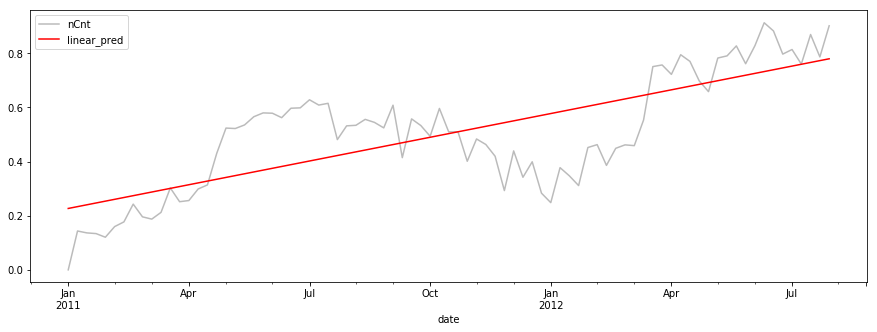

In [16]:
model_linear_pred = model_linear.predict()
week_train['linear_pred'] = model_linear_pred
# Plot the prediction line
week_train.loc[:, ['nCnt','linear_pred']].plot(figsize=(15,5), color=['#bbbbbb','r']);

In [17]:
# Root Mean Squared Error (RMSE) for linear
model_linear_RMSE = RMSE(week_train.linear_pred, week_train.nCnt)

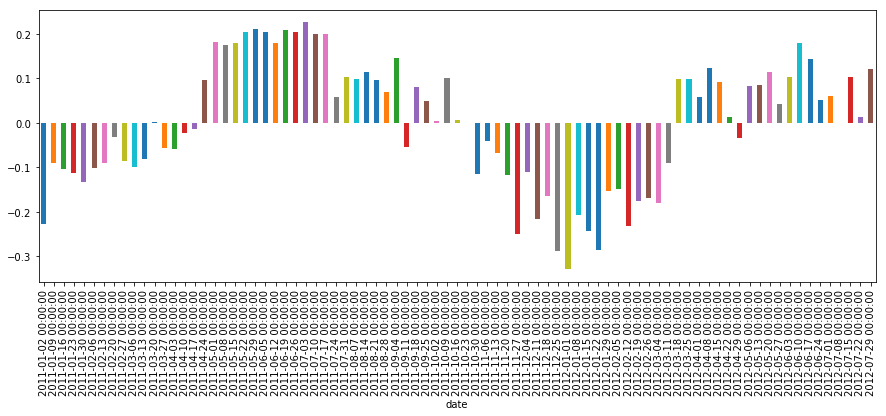

In [18]:
# Plot the residual
plt.figure(figsize=(15,5))
model_linear.resid.plot(kind='bar');

The time pattern is evident in the residual plot. A sinusoidal signal with a period at about 11 months. 

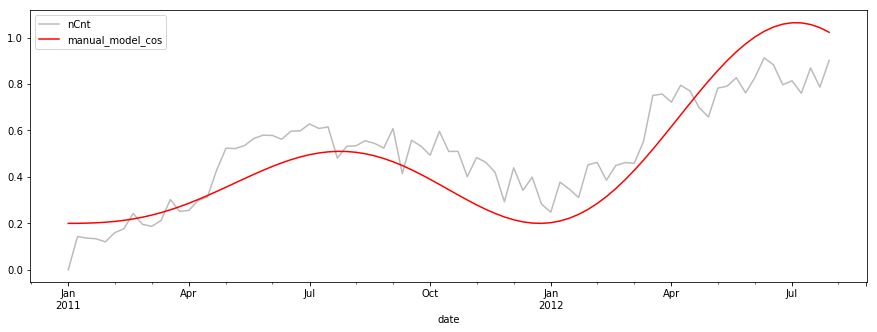

In [21]:
def manual_model(time_indices):
    resolution = 0.5
    period = 10.5/2*np.pi   #10.5 months fits best
    amplitud = 0.25
    amp_adj = 0.044         # precision Adjusted amplitude retrieved by trial and error
    return amplitud*amp_adj*time_indices * np.sin(1/period*time_indices)**2 +0.2

manual_model_preds = manual_model(week_train.time_index.values)
week_train['manual_model_cos'] = manual_model_preds

# Plot the prediction line
week_train.loc[:, ['nCnt','manual_model_cos']].plot(figsize=(15,5), color=['#bbbbbb','r']);

Of course this method also misses all of the week-to-week fluctuations.

In [22]:
# Root Mean Squared Error (RMSE) for manual
model_manual_RMSE = RMSE(week_train.manual_model_cos, week_train.nCnt)

### Forecasts
#### Sine Model

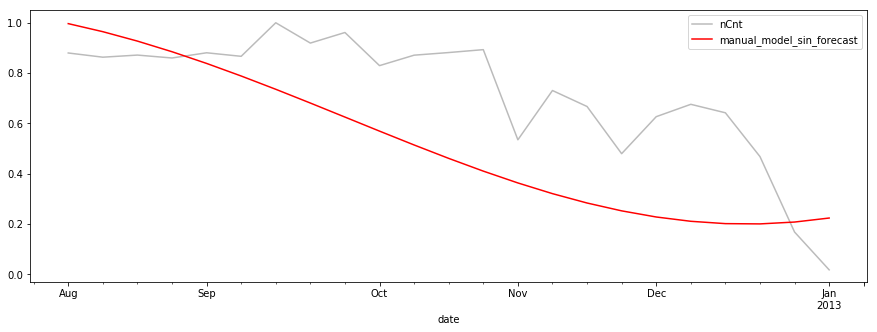

In [23]:
# create indices for test data
week_test['time_index'] = range(week_train.time_index[-1]+1, week_train.time_index[-1]+24)

# Forecast using manual model
model_manual_forecast = manual_model(week_test.time_index.values)
week_test['manual_model_sin_forecast'] = model_manual_forecast

# Plot the prediction line
week_test.loc[:, ['nCnt','manual_model_sin_forecast']].plot(figsize=(15,5), color=['#bbbbbb','r']);

#### Linear model

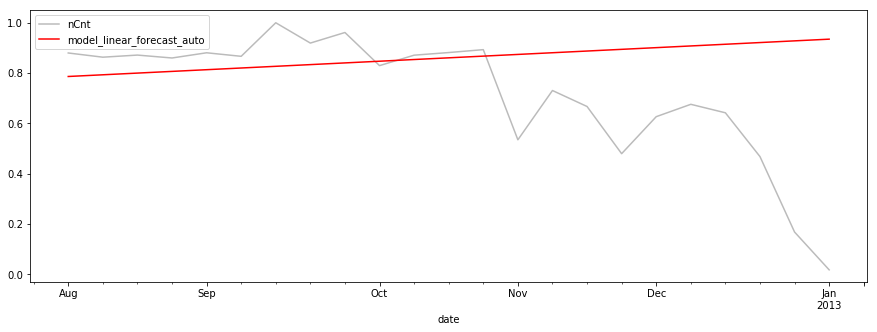

In [24]:
# Using Predict Function
model_linear_forecast_auto = model_linear.predict(exog=week_test.time_index)
week_test['model_linear_forecast_auto'] = model_linear_forecast_auto
# Plot the prediction line
week_test.loc[:, ['nCnt','model_linear_forecast_auto']].plot(figsize=(15,5), color=['#bbbbbb','r']);

#### RMSE

In [25]:
results_week.loc[1,"Model"] = "Linear"
results_week.loc[1,"RMSE"] = model_linear_RMSE

results_week.loc[2,"Model"] = "Manual"
results_week.loc[2,"RMSE"] = model_manual_RMSE
results_week.head()

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13


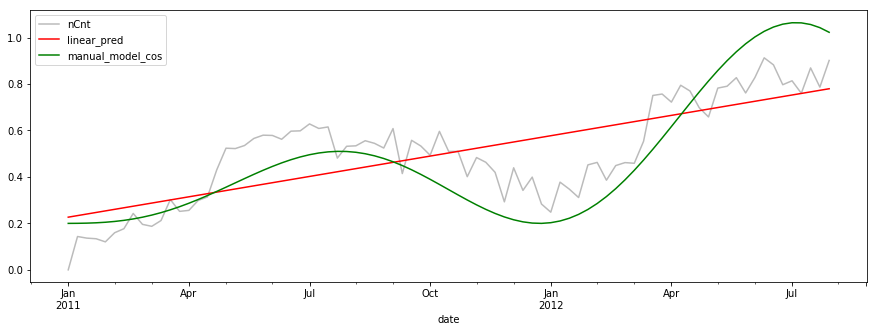

In [26]:
# Plot the prediction lines
week_train.loc[:, ['nCnt','linear_pred','manual_model_cos']]\
    .plot(figsize=(15,5), color=['#bbbbbb', 'r','g','b']);

## Linear Model with Regressor

In [27]:
model_linear_quantity = smf.ols('nCnt ~ atemp', data=week_train).fit()
week_train["linear_regression"] = model_linear_quantity.predict()

In [29]:
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13


In [30]:
# Root Mean Squared Error (RMSE) for linear_quant
model_linQ_RMSE = RMSE(week_train.linear_regression, week_train.nCnt)

results_week.loc[3,"Model"] = "linear_regression"
results_week.loc[3,"RMSE"] = model_linQ_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15


## Random Walk Model

In [31]:
week_train["shift_1_pred"] = week_train.nCnt.shift()
week_train.loc[:,['nCnt','shift_1_pred']].head(5)

,nCnt,shift_1_pred
date,,
2011-01-02,0.00,NaN
2011-01-09,0.14,0.00
2011-01-16,0.14,0.14
2011-01-23,0.13,0.14
2011-01-30,0.12,0.13


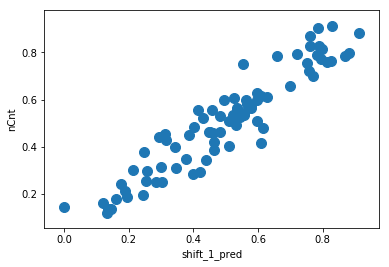

In [32]:
week_train.plot(kind="scatter", y="nCnt", x = "shift_1_pred", s=100);

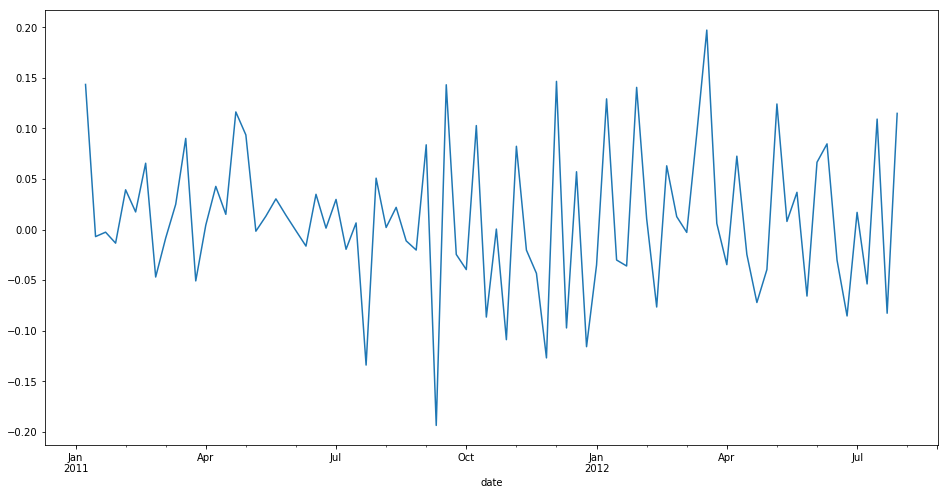

In [33]:
# Lets plot the one-day difference curve
(week_train.nCnt - week_train.shift_1_pred).plot(figsize=(16,8));

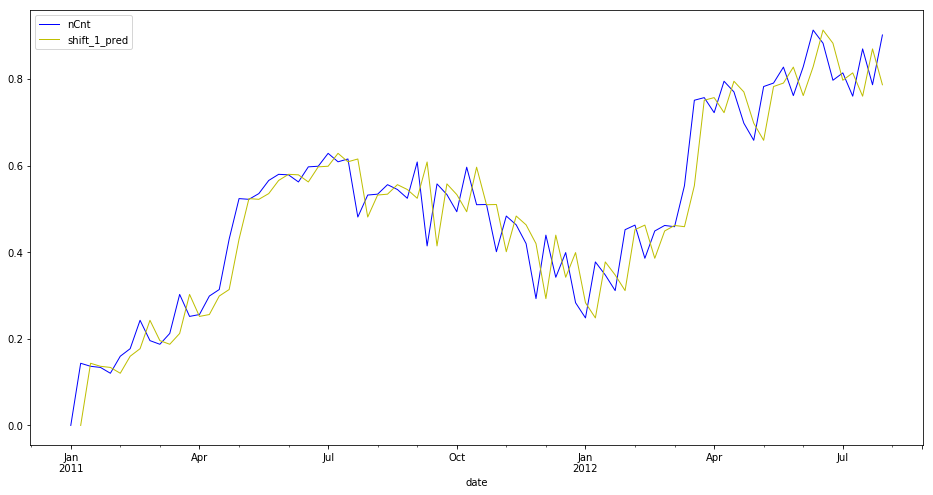

In [34]:
week_train["shift_1_pred"] = week_train.shift_1_pred
week_train.loc[:, ['nCnt', 'shift_1_pred']].plot(color=['b', 'y'], figsize=(16,8), linewidth=1);

In [35]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(week_train.shift_1_pred, week_train.nCnt)

results_week.loc[4,"Model"] = "shift_1_pred"
results_week.loc[4,"RMSE"] = model_random_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15
4,shift_1_pred,0.074


#### Simple Moving Average

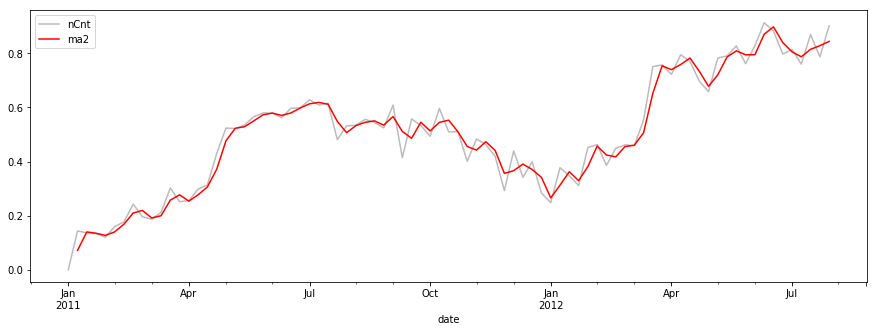

In [36]:
# For smoothing the values we can use 2 week Moving Averages 
week_train['ma2'] = week_train.nCnt.rolling(window=2).mean()
week_train.loc[:, ['nCnt', 'ma2']].plot(color=['#bbbbbb', 'r'], figsize=(15,5));

The long-term forecasts from the SMA model are a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is no trend in the data. However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.

    

In [37]:
model_MA2_forecast = week_train.nCnt.tail(14).mean()

In [38]:
# Root Mean Squared Error (RMSE)
model_MA2_RMSE = RMSE(week_train.ma2, week_train.nCnt)

results_week.loc[5,"Model"] = "Moving Average 2"
results_week.loc[5,"RMSE"] = model_MA2_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15
4,shift_1_pred,0.074
5,Moving Average 2,0.037


In [40]:
# AUGMENTED DICKEY FULLER TEST FOR STATIONARITY
def adf(ts):
    
    # Determing rolling statistics
    rolmean = ts.rolling(window=2).mean()
    rolstd = ts.rolling(window=2).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original', Linewidth=4, alpha=0.5)
    mean = plt.plot(rolmean, color='black', label='Rolling Mean', linestyle='--')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std', linestyle='--')
    plt.legend(loc='best')
    plt.grid('on')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput

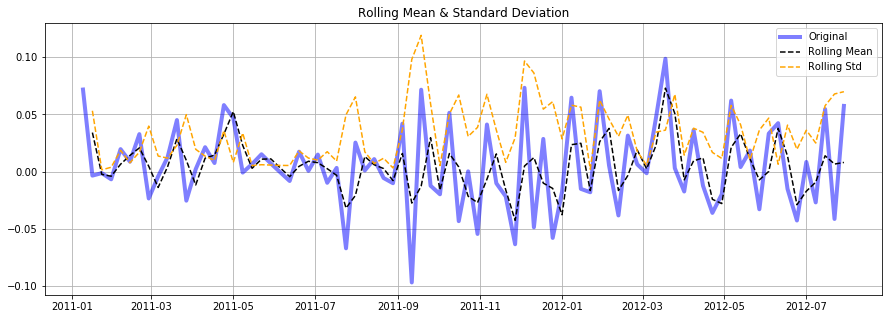

In [42]:
# Test remaining part for Stationary
ts = week_train.nCnt - week_train.ma2
ts.dropna(inplace=True)
fig = plt.figure(figsize=(15,5))
adf(ts)
fig.savefig('../reports/img/Q5ADFTest.png', bbox_inches='tight')

The Test Statistic is lower than all critical values, so we reject the null hypothesis of non-stationarity and say that the series **is stationary**. Even though the variance is not constant, the changes are minimal. 


## Simple Exponential Smoothing Model (SES)

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} $$

In [43]:
week_train['exp2'] = week_train.nCnt.ewm(halflife=1).mean()

In [44]:
halflife = 1
alpha = 1 - np.exp(np.log(0.5)/halflife)    # Smoothing constant
alpha

0.5

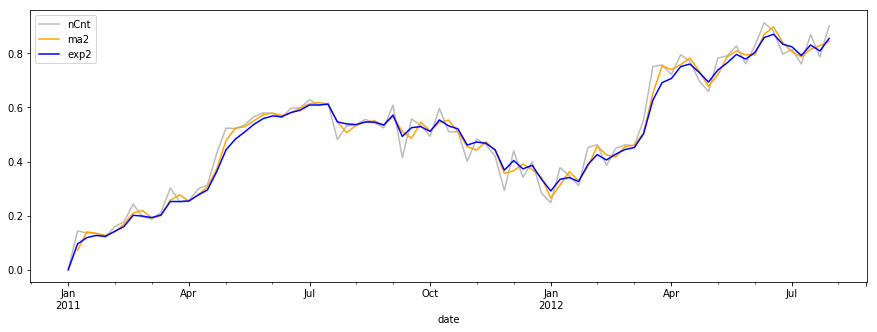

In [45]:
week_train.loc[:, ["nCnt", "ma2", "exp2"]].plot(color=['#bbbbbb','orange','b'], figsize=(15, 5));

In [47]:
# Root Mean Squared Error (RMSE)
model_Exp2_RMSE = RMSE(week_train.exp2, week_train.nCnt)

results_week.loc[6,"Model"] = "SES"
results_week.loc[6,"RMSE"] = model_Exp2_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15
4,shift_1_pred,0.074
5,Moving Average 2,0.037
6,SES,0.036


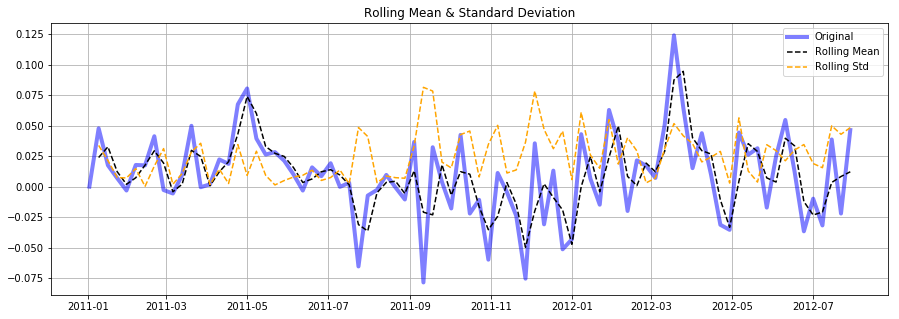

Test Statistic                -7.56e+00
p-value                        3.03e-11
# of Lags Used                 0.00e+00
Number of Observations Used    8.20e+01
Critical Value (1%)           -3.51e+00
Critical Value (5%)           -2.90e+00
Critical Value (10%)          -2.59e+00
dtype: float64

In [49]:
# Test remaining part for Stationary
ts = week_train.nCnt - week_train.exp2
ts.dropna(inplace = True)
plt.figure(figsize=(15,5))
adf(ts)

The ADF test indicates that the series is stationary

## Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. We have already done first order difference earlier

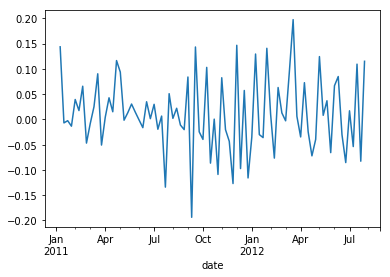

In [50]:
# the first order difference
diff = (week_train.nCnt - week_train.shift_1_pred)
diff.plot();

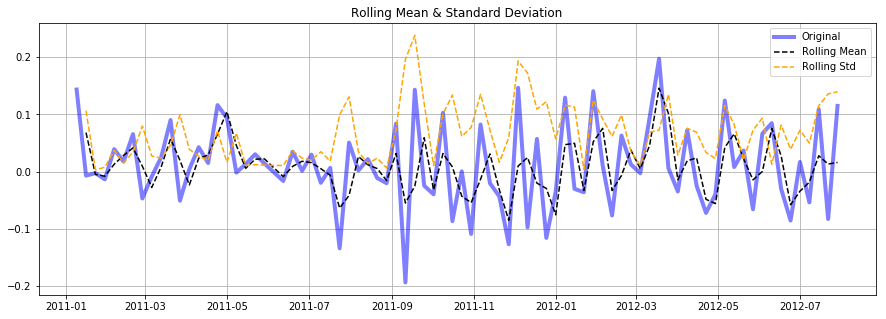

Test Statistic                -1.26e+01
p-value                        1.44e-23
# of Lags Used                 0.00e+00
Number of Observations Used    8.10e+01
Critical Value (1%)           -3.51e+00
Critical Value (5%)           -2.90e+00
Critical Value (10%)          -2.59e+00
dtype: float64

In [51]:
# Test remaining part for Stationary
ts = diff
ts.dropna(inplace=True)
plt.figure(figsize=(15,5))
adf(ts)

Stationary series!

## Time Series Decomposition

We can also decompose the time series into trend and seasonality

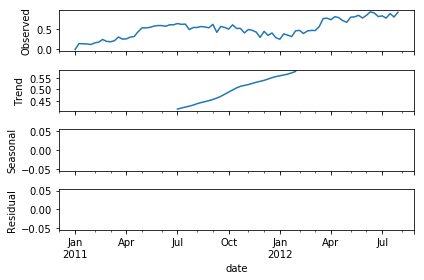

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(week_train.nCnt, model="additive")
decomposition.plot();

In [53]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
week_train['power_decomp'] = trend

In [55]:
# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(week_train.power_decomp, week_train.nCnt)

results_week.loc[7,"Model"] = "Decomp"
results_week.loc[7,"RMSE"] = model_Decomp_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15
4,shift_1_pred,0.074
5,Moving Average 2,0.037
6,SES,0.036
7,Decomp,0.15


In [ ]:
# Test remaining part for Stationary
ts = decomposition.resid
ts.dropna(inplace = True)
adf(ts)

## Auto Regressive Models

In [100]:
# Exp2 is so far the best model so we'll use the difference to use the ARIMA model: 
diff = (week_train.nCnt - week_train.exp2)
ts_diff = diff.copy()          ## diff = (week_train.nCnt - week_train.shift_1_pred)
ts_diff.dropna(inplace=True)

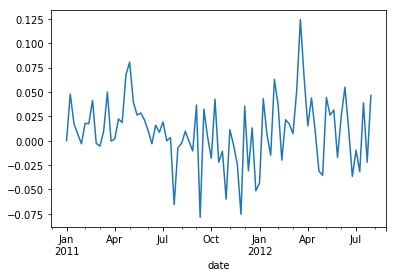

In [101]:
ts_diff.plot()

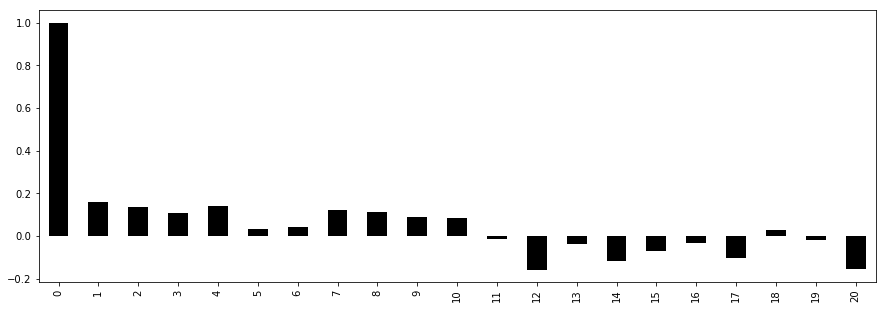

In [102]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
ACF = pd.Series(lag_acf)
ACF.plot(kind="bar", color='k', figsize = (15,5));

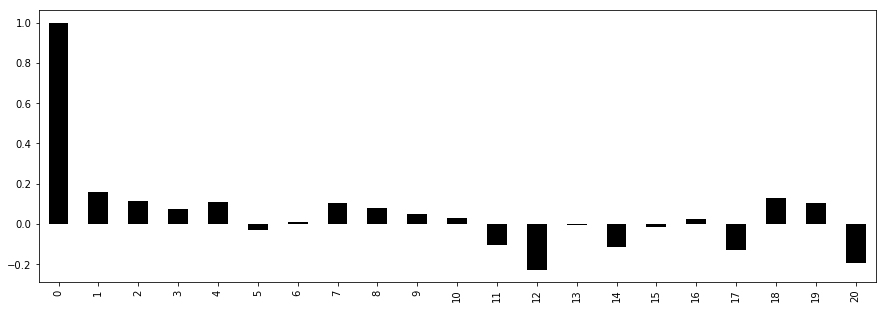

In [103]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind="bar", color='k', figsize = (15,5));

### Running the ARIMA Model 

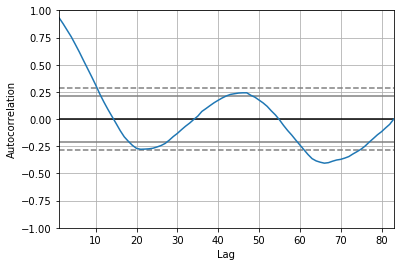

In [122]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(week_train.exp2)
plt.show()

p=10

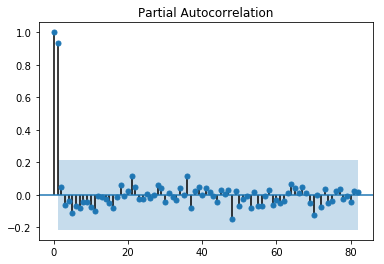

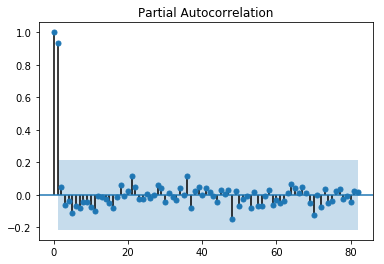

In [123]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(week_train.exp2)

q=2

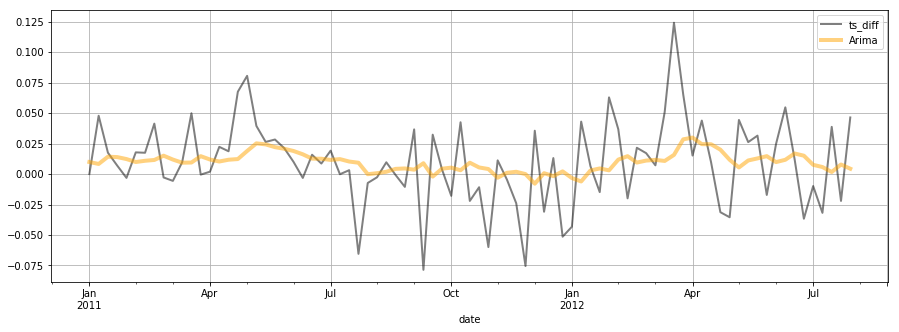

In [192]:
from statsmodels.tsa.arima_model import ARIMA
# Running the ARIMA Model(2,0,2)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
results_ARIMA = model_AR1MA.fit(disp=-1)

# Plot results:
fig = plt.figure(figsize=(15,5))
ts_diff.plot(color='k', linewidth=2, label='ts_diff', alpha=0.5);
results_ARIMA.fittedvalues.plot(color='orange', label='Arima', linewidth=4, alpha=0.5);
plt.legend()
plt.grid()
plt.show()

In [193]:
RMSE(results_ARIMA.fittedvalues, ts_diff)

0.033557704264143326

In [194]:
# Get the predictions of the differenciation: 
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# Undo 1 degree differenciation: 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# Add the first record that thanks to differenciation, got removed. 
predictions_ARIMA = pd.Series(ts.iloc[0], index=ts.index) # SERIES with 0 as values
# either add or sub, depending on the series switch if it comes out upside down
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# Add to Dataframe
week_train['ARIMA'] = predictions_ARIMA

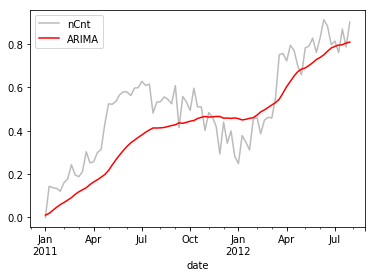

In [195]:
week_train.loc[:, ['nCnt', 'ARIMA']].plot(color=['#bbbbbb','r']);

ARIMA isn't always easy to fine-tune, but it seems to capture the trend well enough and the cycle but not that well enough. 

In [196]:
# Root Mean Squared Error (RMSE)
model_ARIMA_RMSE = RMSE(week_train.ARIMA, week_train.nCnt)

results_week.loc[8,"Model"] = "ARIMA"
results_week.loc[8,"RMSE"] = model_ARIMA_RMSE
results_week

,Model,RMSE
0,Mean,0.21
1,Linear,0.14
2,Manual,0.13
3,linear_regression,0.15
4,shift_1_pred,0.074
5,Moving Average 2,0.037
6,SES,0.036
7,Decomp,0.15
8,ARIMA,0.14


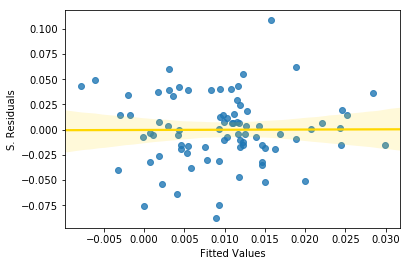

In [197]:
fitted_values = pd.Series(results_ARIMA.fittedvalues, name="Fitted Values")
residuals = pd.Series(results_ARIMA.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
fig=plt.figure()
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.show()

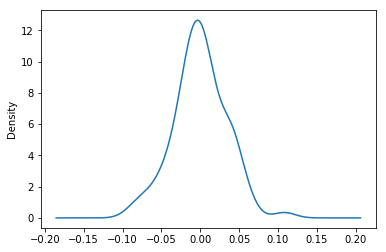

In [198]:
results_ARIMA.resid.plot(kind='kde')

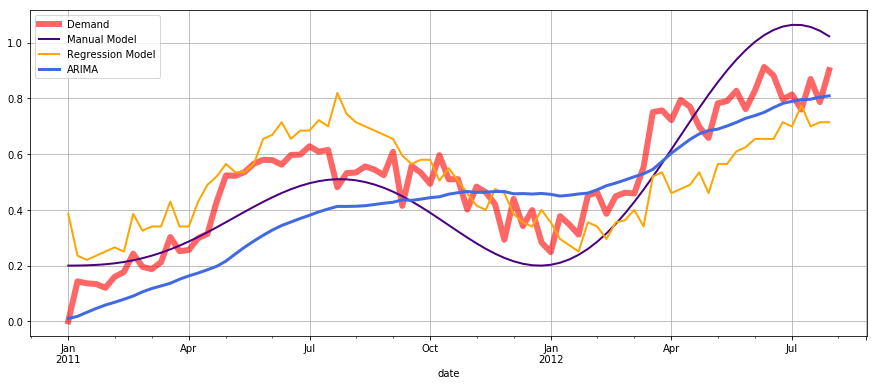

In [201]:
# Plot all good models
fig = plt.figure(figsize=(15,6))
week_train.loc[:, 'nCnt'].plot(color='r', linewidth = 6, label='Demand', alpha=0.6);
week_train.loc[:, 'manual_model_cos'].plot(color='indigo', linewidth = 2, label='Manual Model');
week_train.loc[:, 'linear_regression'].plot(color='orange', linewidth = 2, label='Regression Model');
#week_train.loc[:,'shift_1_pred'].plot(color='green', linewidth = 2, label='Shift 1');
#week_train.loc[:,'ma2'].plot(color='royalblue', linewidth = 3, label='Moving Average');
#week_train.loc[:,'exp2'].plot(color='orange', linewidth = 3, label='Exp Average');
week_train.loc[:,'ARIMA'].plot(color='royalblue', linewidth = 3, label='ARIMA');
plt.grid()
plt.legend()
plt.show()
fig.savefig('../reports/img/Q5AllPredictions.png', bbox_inches='tight')

### Forecast the 14 days in the test set

We will use the 3 best models to predict the demand. 

In [207]:
week_test['exp2'] = week_test.nCnt.ewm(halflife=1).mean()

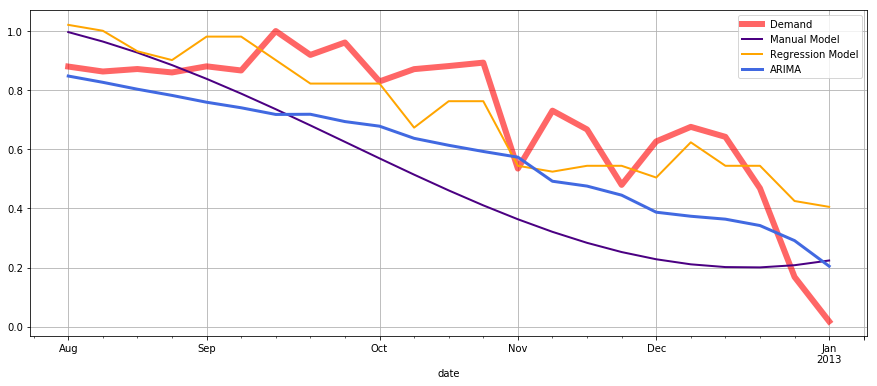

In [215]:
# create indices for test data
week_test['time_index'] = range(week_train.time_index[-1]+1, week_train.time_index[-1]+24)

# Forecast using manual model
model_manual_forecast = manual_model(week_test.time_index.values)
week_test['manual_model_sin_forecast'] = model_manual_forecast

# Forecast using Regression model 
model_regression_forecast = smf.ols('nCnt ~ atemp', data=week_test).fit()
week_test["linear_regression"] = model_regression_forecast.predict()

# Forecast using the ARIMA model 
model_AR1MA_forecast = ARIMA(week_test.nCnt-week_test.exp2, order=(1,0,1))
results_ARIMA_f = model_AR1MA_forecast.fit(disp=-1)
#Undifferenciate
predictions_ARIMA_diff_f = pd.Series(results_ARIMA_f.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_f = predictions_ARIMA_diff_f.cumsum()
predictions_ARIMA_f = pd.Series(week_test.nCnt.iloc[0], index=week_test.nCnt.index) # SERIES with 0 as values
# either add or sub, depending on the series switch if it comes out upside down
predictions_ARIMA_f = predictions_ARIMA_f.add(predictions_ARIMA_diff_cumsum_f, fill_value=0)
# Add to Dataframe
week_test['ARIMA'] = predictions_ARIMA_f

# Plot the prediction line
fig = plt.figure(figsize=(15,6))
week_test.loc[:, 'nCnt'].plot(color='r', linewidth = 6, label='Demand', alpha=0.6);
week_test.loc[:, 'manual_model_sin_forecast'].plot(color='indigo', linewidth = 2, label='Manual Model');
week_test.loc[:, 'linear_regression'].plot(color='orange', linewidth = 2, label='Regression Model');
week_test.loc[:,'ARIMA'].plot(color='royalblue', linewidth = 3, label='ARIMA');
plt.legend()
plt.grid()
plt.show()

In [216]:
final_prediction = pd.DataFrame(columns=['model','RMSE'])

final_prediction.loc[0,'model'] = 'Manual Cosine'
final_prediction.loc[0,'RMSE'] = RMSE(week_test.manual_model_sin_forecast, week_test.nCnt)
final_prediction.loc[1,'model'] = 'Linear Regression'
final_prediction.loc[1,'RMSE'] = RMSE(week_test.linear_regression, week_test.nCnt)
final_prediction.loc[2,'model'] = 'Arima'
final_prediction.loc[2,'RMSE'] = RMSE(week_test.ARIMA, week_test.nCnt)

final_prediction

,model,RMSE
0,Manual Cosine,0.29
1,Linear Regression,0.15
2,Arima,0.19
